In [ ]:
import json
import geopandas as gpd
import pandas as pd

import datetime
import geojson
import numpy as np                   
import matplotlib.pyplot as plt      
import rasterio       
import tsd            # time series downloader for sentinel and landsat
import utils          # IO and coordinate system conversion tools
import vistools       # display tools
import folium
import folium.plugins

In [ ]:
with open('data/landfills_openstreetmap.geojson') as f:
    data = json.load(f)

In [12]:
for k, v in my_first_polygon.items():
    print('key: ', k)
    print('value: ', v)

key:  type
value:  Feature
key:  properties
value:  {'@id': 'relation/102591', 'landuse': 'landfill', 'name': 'OMV Deponie', 'operator': 'OMV', 'type': 'multipolygon'}
key:  geometry
value:  {'type': 'Polygon', 'coordinates': [[[16.6678641, 48.3503814], [16.6672106, 48.348237], [16.6663631, 48.3457996], [16.6653583, 48.3431169], [16.6714033, 48.3407591], [16.6719418, 48.3422859], [16.6726635, 48.3437644], [16.6739783, 48.3453721], [16.6745145, 48.3465898], [16.6746037, 48.3481145], [16.6751143, 48.348911], [16.6724267, 48.3492826], [16.6678641, 48.3503814]], [[16.6684772, 48.3463882], [16.6683615, 48.3464492], [16.6683305, 48.3464724], [16.6684455, 48.3465814], [16.6689926, 48.3464169], [16.6689629, 48.3463191], [16.6688833, 48.3462929], [16.6686958, 48.3463111], [16.6684772, 48.3463882]]]}
key:  id
value:  relation/102591


In [ ]:
my_first_polygon = data['features'][0]['geometry']['coordinates']
print(my_first_polygon)

my_first_point = my_first_polygon[0][0]
print(my_first_point)

[[[16.6678641, 48.3503814], [16.6672106, 48.348237], [16.6663631, 48.3457996], [16.6653583, 48.3431169], [16.6714033, 48.3407591], [16.6719418, 48.3422859], [16.6726635, 48.3437644], [16.6739783, 48.3453721], [16.6745145, 48.3465898], [16.6746037, 48.3481145], [16.6751143, 48.348911], [16.6724267, 48.3492826], [16.6678641, 48.3503814]], [[16.6684772, 48.3463882], [16.6683615, 48.3464492], [16.6683305, 48.3464724], [16.6684455, 48.3465814], [16.6689926, 48.3464169], [16.6689629, 48.3463191], [16.6688833, 48.3462929], [16.6686958, 48.3463111], [16.6684772, 48.3463882]]]
[16.6678641, 48.3503814]


### Filter not polygons

In [32]:
# print percentages of each geometry.type of landfill in data
landfills_types = {}
for i in range(len(data['features'])):
    if data['features'][i]['geometry']['type'] in landfills_types:
        landfills_types[data['features'][i]['geometry']['type']] += 1
    else:
        landfills_types[data['features'][i]['geometry']['type']] = 1
# Turn the number of landfills into percentages
total_landfills = len(data['features'])
landfills_types_per = {}

for k, v in landfills_types.items():
    landfills_types_per[k] = round(v / total_landfills * 100, 2)

print(landfills_types_per)

{'Polygon': 98.87, 'MultiPolygon': 0.18, 'LineString': 0.05, 'Point': 0.91}


Around 1% of the dataset are not polygons. We will filter them out. 

### Study of the locations of the polygons in the dataset

In [19]:
my_dict = {'longitude': [], 'latitude': []}
for i in range(len(data['features'])):
    if data['features'][i]['geometry']['type'] == 'Polygon':
        my_first_point_polygon = data['features'][i]['geometry']['coordinates'][0][0]
        my_dict['longitude'].append(my_first_point_polygon[0])
        my_dict['latitude'].append(my_first_point_polygon[1])

df = pd.DataFrame(my_dict)
print(df.head())

   longitude   latitude
0  16.667864  48.350381
1  52.559522  55.682288
2  23.995894  59.348218
3  11.172639  54.495600
4  60.806194  56.931523


In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
result = gpd.sjoin(gdf, world, how='left')

/home/bertille/miniconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
landfills_percentage = {}

for i in result.name.unique():
    landfills_percentage[i] = result[result.name == i].shape[0] / result.shape[0] * 100

# Order in descending order
landfills_percentage = dict(sorted(landfills_percentage.items(), key=lambda item: item[1], reverse=True))

for k, v in landfills_percentage.items():
    print(k, round(v,2))

print(len(landfills_percentage))

Russia 14.04
Germany 7.25
Ukraine 5.99
United States of America 5.55
Canada 5.13
France 4.6
United Kingdom 4.07
South Africa 4.06
China 3.71
Turkey 2.92
Slovakia 2.8
Italy 2.62
Iran 2.55
Poland 2.53
Austria 1.62
Spain 1.58
Norway 1.43
India 1.37
Australia 1.19
Brazil 1.09
Kazakhstan 1.08
Belarus 1.01
Chile 0.99
Czechia 0.77
Uzbekistan 0.67
Hungary 0.67
Finland 0.63
Dem. Rep. Congo 0.59
Burkina Faso 0.56
Argentina 0.53
Saudi Arabia 0.48
Bolivia 0.48
Sweden 0.47
Romania 0.43
Croatia 0.39
Switzerland 0.38
Algeria 0.38
Serbia 0.37
New Zealand 0.37
Mexico 0.36
Moldova 0.33
Bulgaria 0.33
Belgium 0.32
North Korea 0.31
Japan 0.3
Greece 0.29
Portugal 0.28
Luxembourg 0.28
Iraq 0.28
Indonesia 0.27
Netherlands 0.24
Philippines 0.23
Georgia 0.21
Armenia 0.2
Zimbabwe 0.18
Cuba 0.17
Togo 0.17
Uganda 0.17
Libya 0.17
Colombia 0.15
Morocco 0.15
Kenya 0.14
Benin 0.14
Botswana 0.14
Malaysia 0.13
Zambia 0.12
Qatar 0.12
Kosovo 0.12
Bosnia and Herz. 0.11
South Korea 0.11
Estonia 0.11
Tunisia 0.11
Mauritania 

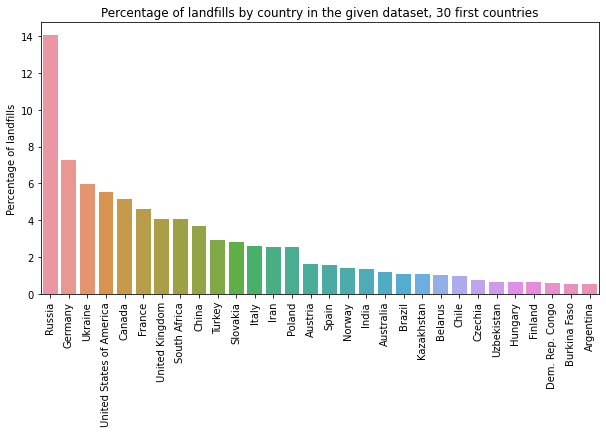

In [30]:
# Make a barplot with percentages by countries
import matplotlib.pyplot as plt
import seaborn as sns

#take 15 first countries
troncated_landfills_percentage = {k: landfills_percentage[k] for k in list(landfills_percentage.keys())[:30]}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(troncated_landfills_percentage.keys()), y=list(troncated_landfills_percentage.values()))
plt.xticks(rotation=90)
plt.ylabel('Percentage of landfills')
plt.title('Percentage of landfills by country in the given dataset, 30 first countries')
plt.show()

In [33]:
# nb of landfills in france
nb_polygons_France = result[result.name == 'France'].shape[0]
print(nb_polygons_France)

2296


For the sake of clarity, all countries are not represented in the barplot. In total 171 countries are represented in the dataset. Only 4.6% of the landfills are located in France, which represents 2296 polygons in France. 

### Generate 10 images and maks using tsd and polygons from the same country. Let's say France

In [ ]:
# Replace single quotes with double quotes in the JSON string
geojsonstring = geojsonstring.replace("'", '"')

# interpret the string as an object
geojsonstruct = geojson.loads(geojsonstring)

# this extracts the geometry field
aoi = utils.find_key_in_geojson(geojsonstruct,'geometry')

my_first_polygon = aoi

In [ ]:
def query_clear_sky(aoi, satellite='Sentinel-2', max_cloud_cover=30, start_date=None, end_date=None):
    if satellite == 'Sentinel-2':
        res = tsd.get_sentinel2.search(aoi, start_date, end_date)
    elif satellite == 'Landsat-8':
        res = tsd.get_landsat.search(aoi, start_date, end_date)

    res2 = []
    for image in res:
      if image.cloud_cover <= max_cloud_cover:
          res2.append(image)
    return res2

In [ ]:
my_first_polygon = data['features'][0]['geometry']
start_date = '2023-01-01'
end_date = '2023-07-01'
image_catalog = tsd.get_sentinel2.search(my_first_polygon, start_date=start_date, end_date=end_date)

AttributeError: 'str' object has no attribute 'isoformat'